##**Visión Dinámica - Práctica Flujo Óptico**

##**Celia García Fernández**

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage.transform import resize
import math
import time

In [ ]:
#código para crear imágenes sintéticas
frame1 = np.ones((100,100))
cv2.rectangle(frame1, pt1=(10,10), pt2=(50,50), color=(0,0,0), thickness=-1)
plt.imshow(frame1, cmap='gray')
frame2 = np.ones((100,100))
cv2.rectangle(frame2, pt1=(17,17), pt2=(57,57), color=(0,0,0), thickness=-1)
plt.figure()
plt.imshow(frame2, cmap='gray')

In [ ]:
def readtwoframes(frame1, frame2, resx, resy):

    frame_1 = cv2.imread(frame1, cv2.IMREAD_GRAYSCALE).astype(float)
    frame_2 = cv2.imread(frame2, cv2.IMREAD_GRAYSCALE).astype(float)
    frame_1 = resize(frame_1, (resx, resy), preserve_range=True)
    frame_2 = resize(frame_2, (resx, resy), preserve_range=True)
    return frame_1, frame_2

def rolling_window(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

def window2(arr, shape=(3, 3)):
    r_extra = np.floor(shape[0] / 2).astype(int)
    c_extra = np.floor(shape[1] / 2).astype(int)
    out = np.empty((arr.shape[0] + 2 * r_extra, arr.shape[1] + 2 * c_extra))
    out[:] = 0
    out[r_extra:-r_extra, c_extra:-c_extra] = arr
    view = rolling_window(out, shape)
    return view

def calculodiferenciales (frame1, frame2, represento):
  frame1  = cv2.GaussianBlur(frame1, (5, 5), 0)
  frame2 = cv2.GaussianBlur(frame2, (5, 5), 0)
  Ix = ndimage.sobel(frame1, 1) + ndimage.sobel(frame2, 1) /2
  Iy = ndimage.sobel(frame1, 0) + ndimage.sobel(frame2, 0) /2
  It = frame2-frame1
  if represento:
    fig, axs = plt.subplots(1,3,figsize=(7,7))
    axs[0].imshow(Ix, cmap='gray')
    axs[1].imshow(Iy, cmap='gray')
    axs[2].imshow(It, cmap='gray')
  return Ix, Iy, It 

def calculovectores_v1(Ix, Iy, It, frame1, w):
  u = np.zeros(frame1.shape)
  v = np.zeros(frame1.shape)
  Ix = window2(Ix, w) # (20,20,3,3) matriz de 20 pixeles, en cada pixel una ventana 3x3
  Iy = window2(Iy, w)
  It = window2(It, w)

  for i in range(0, u.shape[0]-1):
    for j in range(0, u.shape[1]-1):
      # me creo la matriz de gradientes espaciales
      sum_Ix_2 = np.sum((Ix[i][j])**2)
      sum_Iy_2 = np.sum((Iy[i][j])**2)
      sum_Ix_Iy = np.sum((Ix[i][j]) * (Iy[i][j]))
      mat_grad_espaciales = np.matrix([[sum_Ix_2, sum_Ix_Iy],
                                      [sum_Ix_Iy, sum_Iy_2]])
      # me creo el vector de contribución temporal
      sum_Ix_It = np.sum((Ix[i][j]) * (It[i][j]))
      sum_Iy_It = np.sum((Iy[i][j]) * (It[i][j]))
      mat_contrib_temp = np.matrix([[-sum_Ix_It],
                                    [-sum_Iy_It]])
      # calculo V=[u,v], aproximación mínimos cuadrados (con la pseudoinversa)
      vector_pixel = np.linalg.pinv(mat_grad_espaciales) * mat_contrib_temp
      u[i,j]=vector_pixel[0]
      v[i,j]=vector_pixel[1]
  return (u,v)


def calculovectores_v2(Ix, Iy, It, frame1, w):
  u = np.zeros(frame1.shape)
  v = np.zeros(frame1.shape)
  Ix = window2(Ix, w) # (20,20,3,3) matriz de 20 pixeles, en cada pixel una ventana 3x3
  Iy = window2(Iy, w)
  It = window2(It, w)

  for i in range(0, u.shape[0]-1):
    for j in range(0, u.shape[1]-1):
      sum_Ix_2 = np.sum((Ix[i][j])**2)
      sum_Iy_2 = np.sum((Iy[i][j])**2)
      sum_Ix_Iy = np.sum((Ix[i][j]) * (Iy[i][j]))
      sum_Ix_It = np.sum((Ix[i][j]) * (It[i][j]))
      sum_Iy_It = np.sum((Iy[i][j]) * (It[i][j]))

      u1 = -sum_Iy_2*sum_Ix_It + sum_Ix_Iy*sum_Iy_It
      u2 = sum_Ix_2*sum_Iy_2 - sum_Ix_Iy*sum_Ix_Iy
      sum_u = u1/u2

      v1 = sum_Ix_Iy*sum_Ix_It - sum_Ix_2*sum_Iy_It
      v2 = sum_Ix_2*sum_Iy_2 - sum_Ix_Iy*sum_Ix_Iy
      sum_v = v1/v2

      vector_pixel = np.matrix([[sum_u],[sum_v]])
      u[i,j]=vector_pixel[0]
      v[i,j]=vector_pixel[1]
  return (u,v)

def dibujovectores(frame, u, v, step, scale, color):
  ax = plt.figure().gca()
  ax.imshow(frame, cmap = 'gray')
  ax.quiver(np.arange(0, frame.shape[1], step), np.arange(0, frame.shape[1], step),
            u[::step, ::step],v[::step, ::step],angles='xy', scale_units='xy', scale=scale, color=color,
            headwidth=6, headlength = 10)
  plt.savefig('hola.png', format='jpg')

def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
      t = time.time() - startTime_for_tictoc
      print("Elapsed time is " + str(t) + " seconds.")
    else:
      print("Toc: start time not set")
    return float(t)

In [ ]:
#Para las gráficas de tiempos
tam_vent1 = []
tiem1 = []
tam_vent2 = []
tiem2 = []
tam_vent3 = []
tiem3 = []

# Lucas Kanade

In [ ]:
w=(9,9) # tamaño de la vetana
scale = None # escala de las flechas
separacion = 3 # separacion de la cuadricula
frame1, frame2 = readtwoframes('fr00100.png', 'fr00101.png', 100,100)
Ix, Iy, It = calculodiferenciales(frame1, frame2, represento=True)
tic()
u, v = calculovectores_v1(Ix, Iy, It, frame1, w)
toc()
dibujovectores(frame1, u, v, separacion, scale, color='r')
plt.title("9x9", fontdict = {'fontsize':12, 'fontweight':'bold', 'color':'dimgray'})

tic()
u, v = calculovectores_v2(Ix, Iy, It, frame1, w)
toc()
dibujovectores(frame1, u, v, separacion, scale, color='b')


In [ ]:
# Este es para guardarlos tiempos con varias ventanas de integracion
win = [3,5,7,11,15,21,31,45,55,75]
for wi in win:
  w=(wi,wi) # tamaño de la vetana
  scale = None # escala de las flechas
  separacion = 2 # separacion de la cuadricula
  frame1, frame2 = readtwoframes('fr00100.png', 'fr00101.png', 100, 100)
  Ix, Iy, It = calculodiferenciales(frame1, frame2, represento=False)
  tic()
  u, v = calculovectores_v1(Ix, Iy, It, frame1, w)
  time1 = toc()
  tam_vent1.append(w[0])
  tiem1.append(time1)
  dibujovectores(frame1, u, v, separacion, scale, color='r')

  tic()
  u, v = calculovectores_v2(Ix, Iy, It, frame1, w)
  time2 = toc()
  tam_vent2.append(w[0])
  tiem2.append(time2)
  dibujovectores(frame1, u, v, separacion, scale, color='b')

# HORN&SCHUNK

In [ ]:
def calculovectores_hornschunck(Ix, Iy, It, frame1, lamb, delt, num_iter):
  # Inicializo las matrices u y v
  u = np.zeros(frame1.shape)
  v = np.zeros(frame1.shape)
  contador = 0
  while True:
    contador += 1
    # Calculo el promedio de u y de v
    u_promedio = ndimage.median_filter(u, 3)
    v_promedio = ndimage.median_filter(v, 3)

    derivadas = (Ix * u_promedio + Iy * v_promedio + It) / (lamb**2 + Ix**2 + Iy**2)
    prev = u
    u = u_promedio - Ix * derivadas
    v = v_promedio - Iy * derivadas
    #plt.figure()
    #plt.imshow(u - prev, cmap='gray')
    diff = np.linalg.norm(u - prev, 2) # Mido distancia entre matrices con la norma. El residuro/error entre ellas.
    # print('diff: '+str(diff))
    # test = np.abs(np.linalg.norm(u, 2) - np.linalg.norm(prev, 2))
    # print('test: '+str(test))
    # print('diferencia**: '+str(diff-test))
    #Contorl de parada. 
    if  diff < delt or contador > num_iter:
        print("acaba en la iteration numero: ", contador)
        break
  return (u, v)

acaba en la iteration numero:  1
Elapsed time is 0.004296779632568359 seconds.


Text(0.5, 1.0, 'lambda 60, delta 0.3')

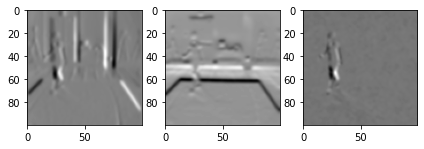

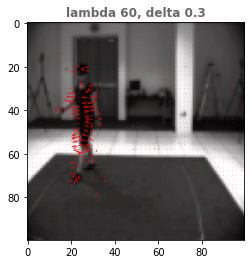

In [ ]:
scale = 0.005 # escala de las flechas
step = 2 # separacion de los vectores en la cuadricula
lamb = 60 # parametro lambda, pondera entre un error y otro. Cuanto mayor es el erro
delt = 0.3
num_iter = 100

frame1, frame2 = readtwoframes('fr00100.png', 'fr00101.png', 100, 100)

Ix, Iy, It = calculodiferenciales(frame1, frame2, represento=True)

#Calculo Flujo optico Horn & Schunck
tic()
u, v = calculovectores_hornschunck(Ix, Iy, It, frame1, lamb, delt, num_iter)
time3 = toc()
dibujovectores(frame1, u, v, step, scale, color='r')
plt.title("lambda 60, delta 0.3", fontdict = {'fontsize':12, 'fontweight':'bold', 'color':'dimgray'})


In [ ]:
tam_vent5 = []
tiem5 = []
lam = [0.1,0.5,1,10,20,30,40,50,60]
#lamb = 0.5
delt = 0.03
it = 100
for la in lam:

  lamb=la # tamaño de la vetana
  scale = None # escala de las flechas
  separacion = 2 # separacion de la cuadricula
  frame1, frame2 = readtwoframes('j8.jpg', 'j9.jpg', 100, 100)
  Ix, Iy, It = calculodiferenciales(frame1, frame2, represento=False)
  tic()
  u, v = calculovectores_hornschunck(Ix, Iy, It, frame1, la, delt, it)
  time5 = toc()
  tam_vent5.append(lamb)
  tiem5.append(time5)
  dibujovectores(frame1, u, v, separacion, scale, color='r')

# Imprimo la gráfica de los tiempos

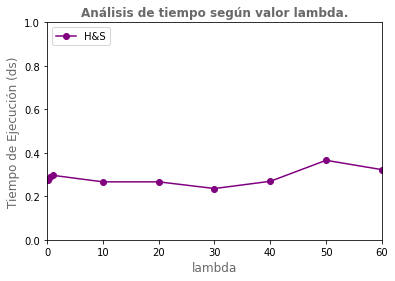

In [ ]:
#plt.plot(tam_vent1, tiem1, 'ro')
fig, ax = plt.subplots()
#plt.plot(tam_vent1, tiem1, 'crimson', label = "Versión 1 LK", marker = 'o')
#plt.plot(tam_vent2, tiem2, 'olivedrab', label = "Versión 2 LK", marker = 'o')
#plt.plot(tam_vent3, tiem3, 'b', label = "H&S l=40 d=0.01, 137 iter", marker = 'o')
plt.plot(tam_vent5, tiem5, 'purple', label = "H&S", marker = 'o')

plt.title("Análisis de tiempo según valor lambda.", fontdict = {'fontsize':12, 'fontweight':'bold', 'color':'dimgray'})
plt.xlabel("lambda", fontdict = {'fontsize':12, 'color':'dimgray'})
plt.ylabel("Tiempo de Ejecución (ds)", fontdict = {'fontsize':12, 'color':'dimgray'})
plt.legend(loc = "upper left")
plt.legend(loc = "upper left")

plt.axis([0, 60, 0, 1])
plt.show()
plt.close()